<a href="https://colab.research.google.com/github/Mayank-goyal2424/Deep_learning/blob/master/Transfer_Learning_From_Pre_Trained_Model_for_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning From Pre-Trained Model (VGG16)  for Face Recognition

### Loading the VGG16 Model

In [0]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes but we are setting image size 100x100 to reduce computing power
img_rows = 100
img_cols = 100

#Loads the VGG16 model 
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [0]:
get_ipython().system_raw("/content/Bollywood_Dataset.rar")

In [6]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/Bollywood_Dataset.rar').extractall('/content/')

     |████████████████████████████████| 81kB 2.3MB/s 


### Inpsecting each layer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


### Let's freeze all layers except the top 4 

In [8]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes but we are setting image size 100x100 to reduce computing power
img_rows = 100
img_cols = 100 

# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's make a function that returns our FC Head

In [0]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [10]:
model.input

<tf.Tensor 'input_4:0' shape=(None, 100, 100, 3) dtype=float32>

In [11]:
model.layers

### Let's add our FC Head back onto VGG

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 10

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

### Loading our Bollywood  Dataset

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/Bollywood_Dataset/Bollywood_Dataset/train'
validation_data_dir = '/content/Bollywood_Dataset/Bollywood_Dataset/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 15
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


### Training our top layers

In [14]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("Bollywood_Dataset.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 300
nb_validation_samples = 100
epochs = 10
batch_size = 15

classifier = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

modelnew.save("Bollywood_Dataset.h5")

Epoch 1/10
20/20 [==============================] - 36s 2s/step - loss: 3.1688 - accuracy: 0.1200 - val_loss: 2.4161 - val_accuracy: 0.2667

Epoch 00001: val_loss improved from inf to 2.41613, saving model to Bollywood_Dataset.h5
Epoch 2/10
20/20 [==============================] - 36s 2s/step - loss: 2.0807 - accuracy: 0.2533 - val_loss: 2.2552 - val_accuracy: 0.2333

Epoch 00002: val_loss improved from 2.41613 to 2.25523, saving model to Bollywood_Dataset.h5
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 1.9186 - accuracy: 0.3167 - val_loss: 0.8900 - val_accuracy: 0.3500

Epoch 00003: val_loss improved from 2.25523 to 0.89005, saving model to Bollywood_Dataset.h5
Epoch 4/10
20/20 [==============================] - 36s 2s/step - loss: 1.7919 - accuracy: 0.3833 - val_loss: 0.5508 - val_accuracy: 0.4000

Epoch 00004: val_loss improved from 0.89005 to 0.55079, saving model to Bollywood_Dataset.h5
Epoch 5/10
20/20 [==============================] - 36s 2s/step - lo

In [0]:
#loading saved model for prediction

from keras.models import load_model
classifier = load_model('Bollywood_Dataset.h5')

In [0]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

actors_dataset_dict = {"[0]": "Aamir Khan", 
                      "[1]": "Akshay Kumar",
                      "[2]": "Hrithik Roshan",
                      "[3]": "Kajal Agarwal",
                      "[4]": "Kareena Kapoor ",
                      "[5]": "Katrina Kaif", 
                      "[6]": "Madhuri Dixit",
                      "[7]": "Salman Khan",
                      "[8]": "ShahRukh Khan",
                      "[9]": "Shilpa Shetty "
                      }



def draw_test(name, pred, im):
    actors = actors_dataset_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, actors, (0, 40) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow( expanded_image)



Class - ShahRukh Khan


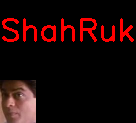

In [31]:
def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + str(path_class))
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    


input_im = getRandomImage("/content/Bollywood_Dataset/Bollywood_Dataset/validation/")
input_original = input_im.copy()
input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
input_im = cv2.resize(input_im, (100, 100), interpolation = cv2.INTER_LINEAR)
input_im = input_im / 255.
input_im = input_im.reshape(1,100,100,3) 
    
    # Get Prediction

res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
draw_test("Prediction", res, input_original) 
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [0]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  98214      0 --:--:-- --:--:-- --:--:-- 98214


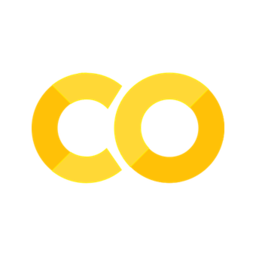

In [22]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)